In [1]:
%matplotlib inline
import os
import sys

import pandas as pd
import numpy as np

BASE_PATH = os.path.dirname(os.getcwd())
sys.path.append(BASE_PATH)

import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
from matplotlib import font_manager, rc


path = '/Users/suhye/Library/Fonts/NanumBarunGothic.otf'
font_name = font_manager.FontProperties(fname=path).get_name()

rc('font', family = 'AppleGothic')

In [4]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

In [5]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
CHANNEL = 3
images = np.zeros((12159, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNEL))
for idx, image in enumerate(train_df['img_path']):
    image_path = os.path.join('../data/', image[2:])
    i = cv2.imread(image_path)
    i = cv2.resize(i, (IMAGE_HEIGHT, IMAGE_WIDTH))/255
    images[idx,:,:,:] = i

In [6]:
images.shape

(12159, 128, 128, 3)

In [7]:
words = list(train_df['text'])

#dataset = (x_train, words)

In [8]:
batch_size = 128
max_len = max([len(word) for word in words]) + 1
unicode_arr = np.ones(shape=(12159,max_len), dtype=np.int) * -1

for idx, text in enumerate(words):
    unicode_arr[idx, :len(text)] = np.array([ord(char) for char in text])
    unicode_arr[idx, len(text)] = ord('\n')
    
decode_inputs = np.roll(unicode_arr,1,axis=1)
decode_inputs[:,0] = ord('\n')
decode_inputs = decode_inputs.astype(np.int32)

/var/folders/7n/pm50m3212tq_hg29f8q2fdh00000gn/T/ipykernel_13987/3534059643.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  unicode_arr = np.ones(shape=(12159,max_len), dtype=np.int) * -1


In [9]:
unicode_arr

array([[44264, 47785, 48120, ...,    -1,    -1,    -1],
       [54620, 49457, 48512, ...,    -1,    -1,    -1],
       [54861, 46972, 50868, ...,    -1,    -1,    -1],
       ...,
       [48149, 50500, 46988, ...,    -1,    -1,    -1],
       [54032, 44208, 51032, ...,    -1,    -1,    -1],
       [54788, 51116,    10, ...,    -1,    -1,    -1]])

In [119]:
unicode_arr.shape

(12159, 23)

In [10]:
X = {
    'images':images,
    'output_sequences':unicode_arr
}
train_gen = (X,)

In [122]:
train_gen[0]['images'][:10].shape

(10, 128, 128, 3)

In [ ]:
train_gen

In [13]:
x_train = images.reshape(-1, 128*128*3)
x_train.shape

(12159, 49152)

In [14]:
x_train = {'images':x_train,
           'output_sequences':unicode_arr}


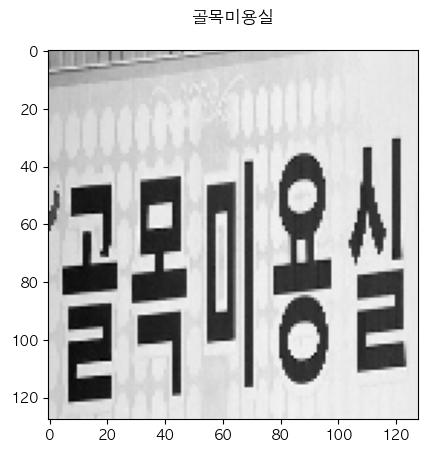

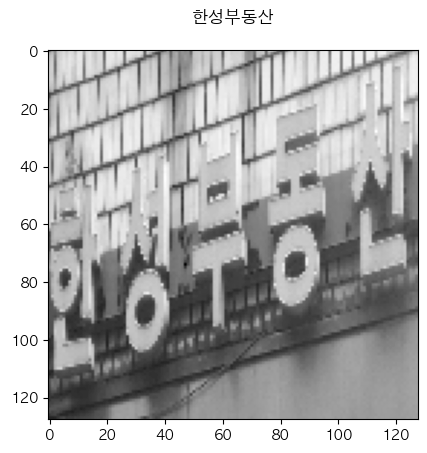

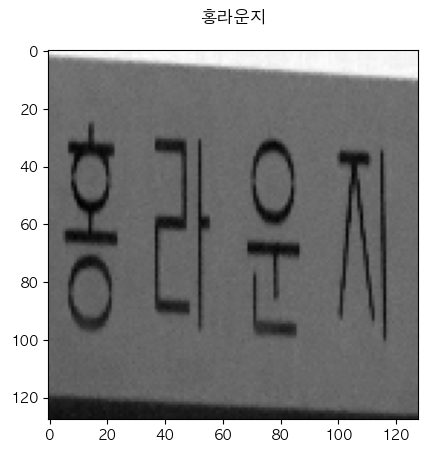

In [11]:
from models.jamo import compose_unicode

X = train_gen[0]
for i in range(3):
    image = X['images'][i,:,:,0]
    plt.title(compose_unicode(X['output_sequences'][i])[0])
    plt.imshow(image, cmap='gray')
    plt.show()

In [13]:
unicode_arr.shape

(12159, 23)

In [12]:
from models.layers import ResidualConvFeatureExtractor
from tensorflow.keras.layers import Input

K.clear_session()

height = 36

n_conv = 16 # the number of Convolution filter
n_state = 256 # the number of GRU units
n_embed = 16 # the size of embedding vector
n_clf = 256 # the number of units in classifier Dense layer

# Image Encoder
inputs = Input(shape=(128, 128, 3),name='images')
conv_maps = ResidualConvFeatureExtractor(n_conv,
                                         name='feature_extractor')(inputs)

2022-10-06 13:28:09.487274: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-06 13:28:09.488542: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [157]:
conv_maps

<KerasTensor: shape=(None, 8, 32, 64) dtype=float32 (created by layer 'feature_extractor')>

In [13]:
from models.layers import Map2Sequence

feature_seqs = Map2Sequence(name='map_to_sequence')(conv_maps)

In [158]:
feature_seqs

<KerasTensor: shape=(None, 32, 512) dtype=float32 (created by layer 'map_to_sequence')>

In [14]:
from models.layers import JamoEmbedding, TeacherForcing

# 교사 강제 학습
y_true = Input(shape=(None,), dtype=tf.int32, name='output_sequences')
decoder_inputs = TeacherForcing()(y_true)

jamo_embedding_layer = JamoEmbedding(n_embed)
jamo_embedding = jamo_embedding_layer(decoder_inputs)

In [15]:
from tensorflow.keras.layers import GRU

# Text Decoder
gru_layer = GRU(n_state, 
                name='decoder_gru', 
                return_sequences=True)
states_decoder = gru_layer(jamo_embedding)

In [16]:
from models.layers import DotAttention
from tensorflow.keras.layers import Concatenate

dotattend = DotAttention(n_state=n_state)
context, attention = dotattend([feature_seqs, states_decoder])

concat_state = Concatenate(axis=-1, name='concat_output')(
    [context, states_decoder])

In [17]:
from models.layers import JamoClassifier

# Classifier Layer
jamo_clf = JamoClassifier(n_clf, name='output_seqs')
y_pred = jamo_clf(concat_state)

In [18]:
from models.losses import JamoCategoricalCrossEntropy

loss = JamoCategoricalCrossEntropy(blank_value=-1.)([y_true, y_pred])

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# For training
trainer = Model([inputs, y_true],[loss], name='trainer')
trainer.add_loss(loss)

# Model 컴파일하기
trainer.compile(Adam(lr=1e-2))

/Users/suhye/miniforge3/envs/newenv/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from multiprocessing import cpu_count

callbacks =[]
rlrop = ReduceLROnPlateau(monitor='val_loss',
    factor=0.5, patience=2, 
    min_lr=1e-6, verbose=1)
callbacks.append(rlrop)

epochs = 50

In [21]:
hist = trainer.fit_generator(train_gen, steps_per_epoch=1000,
                             epochs=epochs, callbacks=callbacks,
                             use_multiprocessing=True, 
                             workers = cpu_count()
                             )

/var/folders/7n/pm50m3212tq_hg29f8q2fdh00000gn/T/ipykernel_13987/4257889486.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = trainer.fit_generator(train_gen, steps_per_epoch=1000,


Epoch 1/50


2022-10-06 13:28:40.054368: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-06 13:28:41.972944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-06 13:28:42.208809: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-10-06 13:28:42.616036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-06 13:28:43.287683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1000/1000 [==============================] - 105s 101ms/step - loss: 6.3082 - lr: 0.0100
Epoch 2/50
1000/1000 [==============================] - 99s 99ms/step - loss: 6.1751 - lr: 0.0100
Epoch 3/50
1000/1000 [==============================] - 99s 99ms/step - loss: 6.1383 - lr: 0.0100
Epoch 4/50
1000/1000 [==============================] - 99s 99ms/step - loss: 6.1166 - lr: 0.0100
Epoch 5/50
1000/1000 [==============================] - 102s 102ms/step - loss: 6.0998 - lr: 0.0100
Epoch 6/50
1000/1000 [==============================] - 99s 99ms/step - loss: 6.0989 - lr: 0.0100
Epoch 7/50
1000/1000 [==============================] - 98s 98ms/step - loss: 6.1045 - lr: 0.0100
Epoch 8/50
1000/1000 [==============================] - 99s 99ms/step - loss: 6.0971 - lr: 0.0100
Epoch 9/50
1000/1000 [==============================] - 98s 98ms/step - loss: 6.1231 - lr: 0.0100
Epoch 10/50
1000/1000 [==============================] - 98s 98ms/step - loss: 6.1549 - lr: 0.0100
Epoch 11/50
1000/1000 [===

In [192]:
trainer.evaluate(train_gen)

2022-10-07 01:55:00.592028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-07 01:55:00.778325: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-10-07 01:55:02.265425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


380/380 [==============================] - 32s 66ms/step - loss: 6.1556


6.155567646026611

In [65]:
trainer.save('model1.h5')

In [66]:
from tensorflow.keras.models import load_model
model = load_model("model1.h5")

### 모델 추론

In [183]:
from models.layers import JamoCompose

# - (1) Encoder
encoder = Model(inputs, feature_seqs, 
                name='encoder')
num_feature = feature_seqs.shape.as_list()[-1]

# - (2) Decoder
states_encoder_input = Input((None, num_feature),
                             name='states_encoder_input')
decoder_state_inputs = Input(shape=(n_state,), name='decoder_state')
decoder_inputs = Input(shape=(None,), name='decoder_inputs')

jamo_embedding = jamo_embedding_layer(decoder_inputs)
states_decoder = gru_layer(jamo_embedding,
                           initial_state=decoder_state_inputs)
context, attention = dotattend([states_encoder_input,
                                states_decoder])
concat_state = Concatenate(axis=-1,name='concat_output')(
    [context, states_decoder])
predictions = jamo_clf(concat_state)
output_decoder = JamoCompose(name='jamocompose')(predictions)

decoder = Model([states_encoder_input,
                 decoder_inputs,
                 decoder_state_inputs], 
                [states_decoder, output_decoder], name='decoder')

### 평가 데이터 가져오기

In [155]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
CHANNEL = 3
target_images = np.zeros((3673, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNEL))
for idx, image in enumerate(test_df['img_path']):
    image_path = os.path.join('../data/', image[2:])
    i = cv2.imread(image_path)
    i = cv2.resize(i, (IMAGE_HEIGHT, IMAGE_WIDTH))/255
    target_images[idx,:,:,:] = i

In [184]:
target_images.shape

(3673, 128, 128, 3)

### Encoder에서 이미지 인코딩

In [156]:
feature_seqs.shape

TensorShape([None, 32, 512])

In [159]:
# Encoder 결과 계산
states_encoder_ = encoder.predict(target_images)

115/115 [==============================] - 7s 48ms/step


In [160]:
states_encoder_.shape

(3673, 32, 512)

In [161]:
batch_size = target_images.shape[0]
batch_size

3673

### Decoder에서 텍스트 디코딩

In [169]:
EOS_TOKEN = ord('\n') # <EOS> 토큰

# Decoder
batch_size = target_images.shape[0]

prev_inputs = np.ones((batch_size,1))
prev_states = np.zeros((batch_size, n_state))

In [172]:
result = np.zeros([batch_size,0])
result

array([], shape=(3673, 0), dtype=float64)

In [191]:
# 재귀적으로 돌아감
result = np.zeros([batch_size,0])
while True:
    states_decoder_, predictions_ = decoder.predict({
        "states_encoder_input" : states_encoder_,
        "decoder_inputs": prev_inputs,
        "decoder_state": prev_states        
    })
    prev_states = states_decoder_[:,-1,:]
    prev_inputs = predictions_
    
    result = np.concatenate([result,prev_inputs],axis=-1)
    if np.all(np.any(result==EOS_TOKEN,axis=1)):
        break    
result = result[:,:].squeeze()
result = result.astype(np.int64)

115/115 [==============================] - 1s 12ms/step


In [154]:
ord('\n')
chr(ord('\n'))

'\n'

In [190]:
result

array([10, 10, 10, ..., 10, 10, 10])

In [189]:
for image, seq in zip(target_images,result):
    text_seq = "".join([chr(char) for char in seq])
    text_seq = text_seq.split('\n')[0]
    
    plt.title(text_seq)
    plt.imshow(image[:,:,0],cmap='gray')
    plt.show()

TypeError: 'numpy.int64' object is not iterable

In [180]:
trainer.summary()

Model: "trainer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 output_sequences (InputLayer)  [(None, None)]       0           []                               
                                                                                                  
 images (InputLayer)            [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 teacher_forcing (TeacherForcin  (None, None)        0           ['output_sequences[0][0]']       
 g)                                                                                               
                                                                                            

In [182]:
target_images.dtype

dtype('float64')

In [193]:
pred = trainer.predict(target_images)

ValueError: in user code:

    File "/Users/suhye/miniforge3/envs/newenv/lib/python3.8/site-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/Users/suhye/miniforge3/envs/newenv/lib/python3.8/site-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/suhye/miniforge3/envs/newenv/lib/python3.8/site-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/suhye/miniforge3/envs/newenv/lib/python3.8/site-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/Users/suhye/miniforge3/envs/newenv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/suhye/miniforge3/envs/newenv/lib/python3.8/site-packages/keras/engine/input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "trainer" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 128, 128, 3) dtype=float32>]


In [187]:
sei = Input((states_encoder_, num_feature))

TypeError: only integer scalar arrays can be converted to a scalar index